# Regresion

Importamos librerias a utilizar

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

Importamos las bases de datos a utilizar

In [2]:
ds_properati = pd.read_csv('dataset_properati_train.csv')
ds_properati_test = pd.read_csv('dataset_properati_test.csv')

Armamos el conjunto de train y test a partir del primer database

In [3]:
x_train = ds_properati.drop(['property_price'], axis='columns', inplace=False)
y_train = ds_properati.property_price.copy()

x_test = ds_properati_test.drop(['property_price'], axis='columns', inplace=False)
y_test = ds_properati_test.property_price.copy()

#### KNN


La lógica de regresión KNN es muy similar a lo que se explicó anteriormente para clasificación.
El algoritmo KNN calculará la regresión para el conjunto de datos y luego tomará la cantidad K de vecinos, verificará los resultados de esos vecinos y promediará los resultados, generando una estimación.

Primero observamos el mapa de correlacion para ver que variables pueden ser buenos features. 

In [4]:
# sns.pairplot(ds_properati)


In [5]:
#Heatmap correlación
ds_properati.corr().style.background_gradient(cmap='coolwarm')

,Unnamed: 0,latitud,longitud,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price
Unnamed: 0,1.000000,-0.003342,-0.000589,0.000231,0.001728,0.000202,0.000167,0.001905
latitud,-0.003342,1.000000,-0.127215,-0.174430,-0.188224,-0.143052,-0.135364,0.100136
longitud,-0.000589,-0.127215,1.000000,-0.228432,-0.224497,-0.217441,-0.204830,-0.177462
property_rooms,0.000231,-0.174430,-0.228432,1.000000,0.895099,0.780283,0.801184,0.673721
property_bedrooms,0.001728,-0.188224,-0.224497,0.895099,1.000000,0.786597,0.802216,0.644713
property_surface_total,0.000202,-0.143052,-0.217441,0.780283,0.786597,1.000000,0.919908,0.784029
property_surface_covered,0.000167,-0.135364,-0.204830,0.801184,0.802216,0.919908,1.000000,0.809772
property_price,0.001905,0.100136,-0.177462,0.673721,0.644713,0.784029,0.809772,1.000000


Podemos ver que los atributos de property_surface_total y property_surface_covered podrian llegar a tener una relacion lineal.

In [6]:
#selecciono variables regresoras y a predecir
X = x_train[['property_surface_total','property_surface_covered']]
X_test = x_test[['property_surface_total','property_surface_covered']]
Y = y_train.copy()

In [7]:
#Heatmap correlación
X.corr().style.background_gradient(cmap='coolwarm')

,property_surface_total,property_surface_covered
property_surface_total,1.000000,0.919908
property_surface_covered,0.919908,1.000000


<AxesSubplot: xlabel='property_surface_total', ylabel='property_price'>

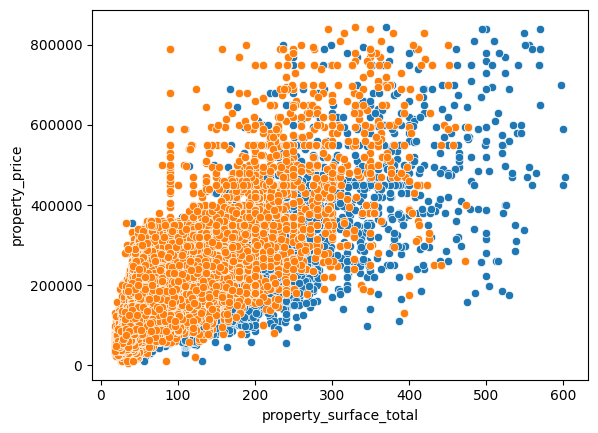

In [8]:
sns.scatterplot(x=X.property_surface_total,y=Y)
sns.scatterplot(x=X.property_surface_covered,y=Y)

Vemos que hay gran relacion entre las dos.

In [9]:
#Grafico de a pares incluyendo variable a predecir
# xy_train = pd.concat([X, Y], axis=1)
# sns.pairplot(xy_train)

Creamos un modelo KNN regresor ahora 

In [10]:
from sklearn.neighbors import KNeighborsRegressor

# Creo un modelo KNN para regresion y lo ajusto
knn_regressor = KNeighborsRegressor().fit(X, Y)

#Hago una predicción
y_pred=knn_regressor.predict(X_test)

Comparamos la performance del Clasificador Regresor

In [11]:
# Performance
performance = pd.DataFrame({'Valor Real': y_test,
                            'Prediccion': y_pred,
                            'Error': y_test - y_pred})
# View
performance.head(10)

,Valor Real,Prediccion,Error
0,79000.0,103598.0,-24598.0
1,99000.0,127600.0,-28600.0
2,160000.0,131843.2,28156.8
3,153000.0,190800.0,-37800.0
4,159000.0,138600.0,20400.0
5,145000.0,125129.0,19871.0
6,89900.0,80400.0,9500.0
7,129500.0,218500.0,-89000.0
8,89900.0,132940.0,-43040.0
9,95000.0,152200.0,-57200.0


Observamos que tenemos un poco de error en las predicciones. Procedemos a buscar los mejores parametros

In [12]:

# #Parámetros a optimizar
# params_grid = {'weights':['uniform', 'distance'],
#           'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'],
#           'n_neighbors':list(range(5,10)),
#           'leaf_size': list(range(25,35)),
#           'p' : [1,2],
#          }

# #Folds
# kfoldcv = StratifiedKFold(n_splits=5)

# #Ramdom Search CV
# randomcv = RandomizedSearchCV(KNeighborsClassifier(), params_grid, n_jobs=10, scoring='roc_auc',cv=kfoldcv, n_iter=10)
# randomcv.fit(x_train,y_train)

# print (randomcv.best_score_, randomcv.best_params_)

# #Mejor Modelo
# kn_best = randomcv.best_estimator_
# # #Conjunto de parámetros que queremos usar

https://www.projectpro.io/recipes/use-nearest-neighbours-for-regression

In [41]:
from sklearn.preprocessing import StandardScaler
from sklearn import decomposition, datasets
from sklearn import neighbors
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score

std_slc = StandardScaler()
pca = decomposition.PCA()
pipe = Pipeline(steps=[("std_slc", std_slc),
                           ("pca", pca),
                           ("KNN", knn_regressor)])

In [39]:
n_components = list(range(1,X.shape[1]+1,1))
n_neighbors = [2, 3, 5, 10]
algorithm = ["auto",  "ball_tree", "kd_tree", "brute"]

parameters = dict(pca__n_components=n_components,
                    KNN__n_neighbors=n_neighbors,
                    KNN__algorithm=algorithm)

In [43]:
clf = GridSearchCV(pipe, parameters)
clf.fit(X, Y)

GridSearchCV(estimator=Pipeline(steps=[('std_slc', StandardScaler()),
                                       ('pca', PCA()),
                                       ('KNN', KNeighborsRegressor())]),
             param_grid={'KNN__algorithm': ['auto', 'ball_tree', 'kd_tree',
                                            'brute'],
                         'KNN__n_neighbors': [2, 3, 5, 10],
                         'pca__n_components': [1, 2]})

In [45]:
print("Best Number Of Components:", clf.best_estimator_.get_params()["pca__n_components"])
print(); print(clf.best_estimator_.get_params()["KNN"])

CV_Result = cross_val_score(clf, X, Y, cv=3, n_jobs=-1, scoring="r2")
print(); print(CV_Result)
print(); print(CV_Result.mean())
print(); print(CV_Result.std())

Best Number Of Components: 2

KNeighborsRegressor(algorithm='brute', n_neighbors=10)

[0.68538369 0.68534095 0.67722742]

0.6826506860435737

0.0038348678983434396


In [13]:
# Creo un modelo KNN para regresion y lo ajusto
knn_regressor = KNeighborsRegressor().fit(X, Y)

#Hago una predicción
y_pred_train=knn_regressor.predict(X)

Comparamos con el conjunto de evaluacion

In [14]:
# Performance
performance = pd.DataFrame({'Valor Real': y_train,
                            'Prediccion': y_pred_train,
                            'Error': y_train - y_pred})
# View
performance.head(10)

ValueError: operands could not be broadcast together with shapes (39663,) (39664,) 

Evaluamos las metricas en el conjunto de entrenamiento

In [ ]:
from sklearn import metrics

#Mean Square Error
mse = metrics.mean_squared_error(
        y_true  = y_train,
        y_pred  = y_pred_train,
        squared = True
       )

print(f"El error (mse) de test es: {mse}")

#Root Mean Square Error
rmse = metrics.mean_squared_error(
        y_true  = y_train,
        y_pred  = y_pred_train,
        squared = False
       )

print(f"El error (rmse) de test es: {rmse}")

El error (mse) de test es: 1880602204.6255815
El error (rmse) de test es: 43365.91062834472


Ahora con el conjunto de test

In [ ]:
# Creo un modelo KNN para regresion y lo ajusto
knn_regressor = KNeighborsRegressor().fit(X, Y)

#Hago una predicción
y_pred_test=knn_regressor.predict(X_test)

Ahora evaluamos con las Metricas:

In [ ]:
#Metricas para evaluar modelos
from sklearn import metrics

#Mean Square Error
mse = metrics.mean_squared_error(
        y_true  = y_test,
        y_pred  = y_pred_test,
        squared = True
       )

print(f"El error (mse) de test es: {mse}")

#Root Mean Square Error
rmse = metrics.mean_squared_error(
        y_true  = y_test,
        y_pred  = y_pred_test,
        squared = False
       )

print(f"El error (rmse) de test es: {rmse}")

El error (mse) de test es: 1882631460.3182845
El error (rmse) de test es: 43389.301219520516


- MSE (Mean Square Error o error cuadrático medio)
    Medida de qué tan cercana es la recta de regresión a los puntos que representan los datos. Mientras más chico más cerca está nuestro modelo de los datos reales. Al ser un valor elevado al cuadrado, es sensible a valores de diferencias grandes.
    
    $MSE= \frac{1}{n}\sum_{i=1}^n  (y_i'-y_i)²$
- RMSE (Root Mean Square Error o raíz del error cuadrático medio)
    
    Tiene las mismas unidades que los valores representados en el eje vertical. Es la distancia de un punto hasta la recta de regresión, medida en línea recta. Mide el desvío estándar (cuánto se alejan los valores de la media).
    
    $RMSE= \sqrt{\frac{1}{n}\sum_{i=1}^n  (y_i'-y_i)²}$

Consideramos que las metricas adecuadas segun el modelo de KNN son las 

In [ ]:
#Coef. de Determinación R2
score_knn = knn_regressor.score(X_test, y_test)
score_knn

### XG BOOST

XGBoost es una forma más regularizada de Gradient Boosting . XGBoost utiliza la regularización avanzada (L1 y L2), que mejora las capacidades de generalización del modelo.

Ofrece un alto rendimiento en comparación con Gradient Boosting. Su entrenamiento es muy rápido y se puede paralelizar entre clústeres.

Fue diseñado para Big Data, es decir para conjuntos de datos grandes y complejos.

XG Boost puede usarse para problemas de regresión o de clasificación.

Pasos:

1. Hacer una predicción inicial. Esta predicción puede ser cualquier valor.
2. Construir un árbol para los residuos. Este árbol es diferente a los usados por Gradient Boost. Primero se crea un nodo hoja y se ponen allí **todos** los residuos.
3. Calcular el ***Similarity Score***, para los residuos: $Similarity Score=\frac{(\sum{residuos)^2}}{\#residuos + \lambda}$
4. Tenemos que ver cuál será el siguiente nodo. Para ello vamos a calcular la **ganancia total** (Gain), según escojamos una opción u otra para partir el árbol (qué umbral tomemos). Nos quedamos con el umbral que de la mayor información ganada.
5. Repetimos el anterior hasta alcanzar la profundidad del árbol estipulada.
6. Poda:
    - Elegimos un número al azar → este número se llama gamma ( **𝜸** )
    - Calculamos la diferencia entre el **Gain** del nodo más bajo y **gamma**
    - Si la diferencia es < 0 → removemos el nodo
    - Sino, el nodo se queda y se terminó la poda
7. Volvemos a calcular el árbol (repite paso 3), solo que esta vez usamos lambda 𝛌 igual a 1 al calcular el Similarity Score y el Gain.
8. Podamos (paso quinto nuevamente).
9. Con estos nuevos residuos, construimos un nuevo árbol.
Repetimos todo, desde el paso 2.
Con el nuevo árbol, calculamos la salida de cada elemento y luego los residuos.
Construimos otro árbol.
Seguimos hasta que los residuos son prácticamente cero o bien alcanzamos el número máximo de árboles predefinido.

Hiper-parámetros

- learning_rate: tasa de aprendizaje

- max_depth: máxima profundidad de cada árbol

- subsample: porcentaje de muestras usadas para cada árbol (valor muy bajo, posible underfitting)

- colsample_bytree: porcentaje de features usadas para cada árbol (valores muy alto, posible overfitting)n_estimators: cantidad de árboles a construir.

- objective: función de error a utilizar (algunas: reg:linear para regresión,

- reg:logistic

- binary:logistic para clasificación)

Parámetros de regularización:

- gamma: umbral para hacer split basado en la reducción de error de hacer el nuevo split.

- alpha: regularización para los pesos de las hojas. Un valor más alto genera una mayor regularización.

- lambda: similar alpha pero para la sintonia fina.

Los parametros se agregan al modelo para evitar el overfitting

CREAMOS EL MODELO

In [16]:
!pip install xgboost==1.6.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.9/255.9 MB 5.4 MB/s eta 0:00:00
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [35]:
#Creo el modelo y lo entreno
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
le = LabelEncoder()
y_train = le.fit_transform(y_train)
x_train = le.fit_transform(x_train)
# print(y_train.head(10))

xgb_model = xgb.XGBRegressor(random_state=0, n_estimators=100)
xgb_model.fit(x_train, y_train)

ValueError: y should be a 1d array, got an array of shape (39663, 14) instead.

Evaluamos sobre el conjunto de entrenamiento

In [18]:
y_pred_proba= xgb_model.predict_proba(x_train)[:, 1]
print('AUC:',roc_auc_score(y_train, y_pred_proba))

#Matriz de Confusion
y_pred=xgb_model.predict(x_train)

cm = confusion_matrix(y_train,y_pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

#Reporte
print(classification_report(y_test,y_pred))

NotFittedError: need to call fit or load_model beforehand

Ahora evaluamos sobre el conjunto de test para observar su prediccion

In [ ]:
y_pred_proba= xgb_model.predict_proba(x_test)[:, 1]
print('AUC:',roc_auc_score(y_test, y_pred_proba))

#Matriz de Confusion
y_pred=xgb_model.predict(x_test)

cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

#Reporte
print(classification_report(y_test,y_pred))

Ahora optimizamos los hiperparametros a traves de KFold cross validation con 5 folds

In [29]:
#dictionary for collecting results
results_dict = {}

#obtaining default parameters by calling .fit() to XGBoost model instance
xgbc0 = xgb.XGBClassifier(objective='binary:logistic',
                          booster='gbtree',
                          eval_metric='auc',
                          tree_method='hist',
                          grow_policy='lossguide',
                          use_label_encoder=False)
xgbc0.fit(x_train , y_train)
#extracting default parameters from benchmark model
default_params = {}
gparams = xgbc0.get_params()

#default parameters have to be wrapped in lists - even single values - so GridSearchCV can take them as inputs
for key in gparams.keys():
    gp = gparams[key]
    default_params[key] = [gp]

#benchmark model. Grid search is not performed, since only single values are provided as parameter grid.
#However, cross-validation is still executed
clf0 = GridSearchCV(estimator=xgbc0, scoring='accuracy', param_grid=default_params, return_train_score=True, verbose=1, cv=3)
clf0.fit(x_train, y_train.values.ravel())

#results dataframe
df = pd.DataFrame(clf0.cv_results_)

#predictions - inputs to confusion matrix
train_predictions = clf0.predict(x_train)
test_predictions = clf0.predict(X_test)

#confusion matrices
cfm_train = confusion_matrix(y_train, train_predictions)
cfm_test = confusion_matrix(y_test, test_predictions)

#accuracy scores
accs_train = accuracy_score(y_train, train_predictions)
accs_test = accuracy_score(y_test, test_predictions)

#F1 scores for each train/test label
f1s_train_p1 = f1_score(y_train, train_predictions, pos_label=1)
f1s_train_p0 = f1_score(y_train, train_predictions, pos_label=0)
f1s_test_p1 = f1_score(y_test, test_predictions, pos_label=1)
f1s_test_p0 = f1_score(y_test, test_predictions, pos_label=0)

#Area Under the Receiver Operating Characteristic Curve
test_ras = roc_auc_score(y_test, clf0.predict_proba(X_test)[:,1])

#best parameters
bp = clf0.best_params_

#storing computed values in results dictionary
results_dict['xgbc0'] = {'iterable_parameter': np.nan,
                         'classifier': deepcopy(clf0),
                         'cv_results': df.copy(),
                         'cfm_train': cfm_train,
                         'cfm_test': cfm_test,
                         'train_accuracy': accs_train,
                         'test_accuracy': accs_test,
                         'train F1-score label 1': f1s_train_p1,
                         'train F1-score label 0': f1s_train_p0,
                         'test F1-score label 1': f1s_test_p1,
                         'test F1-score label 0': f1s_test_p0,
                         'test roc auc score': test_ras,
                         'best_params': bp}


ValueError: DataFrame.dtypes for data must be int, float, bool or category.  When
categorical type is supplied, DMatrix parameter `enable_categorical` must
be set to `True`. Invalid columns:created_on, provincia, barrio, operation, property_type, property_currency, geometry

Arriba tenemos una metrica no explicada anteriormente:

- Curva Roc: es un grafico mostrando la performance del modelo, con dos parametros, True Positive Rate y False Positive Rate.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=fcb02109-3268-4805-81b4-1fba96795907' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>